In [1]:
import xarray as xr
import climtas.io
import dask
import numpy as np
import sys
sys.path.append('/home/563/rl5183/PhD-research/Functions')
import functions as func
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [3]:
import dask.distributed
import tempfile
tempdir = tempfile.TemporaryDirectory("dask-worker-space")
dask.distributed.Client(local_directory=tempdir.name, memory_limit='16gb')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43591 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:44307 Dashboard: http://127.0.0.1:43591/status,Cluster Workers: 4 Cores: 4 Memory: 44.92 GiB


In [4]:
precip_ds = xr.open_dataset('/g/data/w40/rl5183/20CR/precip/monthly_Rx1day_all_members_1x1.nc', chunks={'member':1, 'time':200, 'lat':180, 'lon':360})
precip_data = precip_ds.PRATE.sel(time=slice('1901-11', '2015-10'))*86400
precip_data

,Array,Chunk
Bytes,52.84 GiB,98.88 MiB
Shape,"(80, 1368, 180, 360)","(1, 200, 180, 360)"
Count,1921 Tasks,560 Chunks
Type,float64,numpy.ndarray


### Open HadISST dataset

In [5]:
hadisst_ds = xr.open_dataset('/g/data/eg3/jxb548/OBSDATA/hadisstv1.1870_2017.nc')
sst_data = hadisst_ds.sst

In [6]:
# Detrend HadISST data
sst_data_detrend = np.apply_along_axis(func.detrend_2step, 0, sst_data)
sst_detrended = xr.DataArray(sst_data_detrend, coords=sst_data.coords, attrs=sst_data.attrs)

In [7]:
# Nino3.4 index with HadiSSTv1
nino34_region = sst_detrended.sel(latitude=slice(5,-5), longitude=slice(-170,-120))
climatology = nino34_region.sel(time=slice('1950-01','1979-12')).groupby('time.month').mean()
monthly_anomalies = (nino34_region.groupby('time.month')-climatology).mean(dim=['latitude','longitude'])
monthly_anomalies_rolling = monthly_anomalies.rolling(time=5).mean()
sst_std = nino34_region.sel(time=slice('1950-01','1979-12')).std()
nino34_index = monthly_anomalies_rolling.sel(time=slice('1901-11', '2015-10'))/sst_std

In [8]:
# Take the mean over every quarter
quarterly_nino = nino34_index.resample(time='QS-NOV').mean('time')

# Select out NDJ nino34 index
nino_ndj = quarterly_nino.isel(time=slice(0,None,4))

In [9]:
def ensemble_correlation(data, nino):
    
    # Take max over every quarter 
    quarterly_data = data.resample(time='QS-NOV').max('time')

    # Calculate instantaneous correlation
    quarterly_correlation = func.correlate_nino_by_month(quarterly_data, nino)
    
    return quarterly_correlation

In [10]:
%%time 
correlation_list = []
for m in precip_data.member:
    correlation_list.append(ensemble_correlation(precip_data.sel(member=m), nino_ndj))

CPU times: user 2h 43min 7s, sys: 19min 5s, total: 3h 2min 12s
Wall time: 3h 13min 17s


In [11]:
correlations = xr.concat(correlation_list, dim='member')

In [12]:
correlations

<xarray.DataArray (member: 80, month: 4, lat: 180, lon: 360)>
array([[[[ 1.47520882e-01,  1.46968323e-01,  1.46948439e-01, ...,
           1.51052233e-01,  1.50303135e-01,  1.49060897e-01],
         [ 6.54659442e-02,  6.68536766e-02,  6.77225740e-02, ...,
           6.56869452e-02,  6.55568359e-02,  6.57257503e-02],
         [-9.38519143e-03, -6.55595151e-03, -4.10674878e-03, ...,
          -1.34145224e-02, -1.17442291e-02, -1.08778157e-02],
         ...,
         [ 3.31853004e-02,  4.11124477e-02,  4.91197509e-02, ...,
           1.67263014e-02,  2.05586308e-02,  2.51498016e-02],
         [ 8.51670822e-02,  8.65781797e-02,  8.89334180e-02, ...,
           8.15154588e-02,  8.22285583e-02,  8.36670433e-02],
         [ 1.11644067e-01,  1.12297025e-01,  1.12966597e-01, ...,
           1.09226381e-01,  1.09698990e-01,  1.10836617e-01]],

        [[-6.42345366e-02, -6.54733303e-02, -6.57919545e-02, ...,
          -6.37228677e-02, -6.38497540e-02, -6.38655987e-02],
         [-4.25426723e-02, -4.31272415e-02, -4.34862252e-02, ...,
          -3.88962989e-02, -3.85802841e-02, -3.99404005e-02],
         [-1.49813901e-02, -1.32736488e-02, -1.38567353e-02, ...,
          -1.80889151e-02, -1.64012771e-02, -1.52696890e-02],
...
         [-2.35962462e-02, -2.68539441e-02, -3.04017075e-02, ...,
          -2.56355047e-02, -2.47516938e-02, -2.47136381e-02],
         [ 4.54683149e-02,  4.46286426e-02,  4.41133923e-02, ...,
           3.78648799e-02,  4.04304667e-02,  4.28637754e-02],
         [ 1.08798811e-01,  1.09459009e-01,  1.10192452e-01, ...,
           1.05051099e-01,  1.06804482e-01,  1.07626739e-01]],

        [[-1.32983552e-01, -1.33463134e-01, -1.34037486e-01, ...,
          -1.33951612e-01, -1.33739536e-01, -1.33733802e-01],
         [-8.04279761e-02, -8.13577477e-02, -8.17077113e-02, ...,
          -7.94531696e-02, -8.04896299e-02, -8.01880984e-02],
         [-7.73824461e-02, -7.71087929e-02, -7.72582890e-02, ...,
          -7.37303841e-02, -7.36757529e-02, -7.53784167e-02],
         ...,
         [ 7.72546832e-02,  7.29650586e-02,  6.86312861e-02, ...,
           8.69255012e-02,  8.35522530e-02,  8.10812106e-02],
         [ 1.15537597e-01,  1.16228098e-01,  1.15994015e-01, ...,
           1.15161530e-01,  1.15165110e-01,  1.15641036e-01],
         [ 1.21811482e-01,  1.22674181e-01,  1.22851984e-01, ...,
           1.17588002e-01,  1.18554500e-01,  1.20382987e-01]]]])
Coordinates:
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 72 73 74 75 76 77 78 79 80
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * month    (month) int64 2 5 8 11

In [13]:
# Save as netcdf
correlations.to_netcdf('/g/data/w40/rl5183/20CR/precip/Rx1day_correlations_all_members_1901_2015.nc')

In [2]:
correlations = xr.open_dataarray('/g/data/w40/rl5183/20CR/precip/Rx1day_correlations_all_members_1901_2015.nc')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/local/eg3/rl5183/tmp/ipykernel_2449569/2655956381.py:21: MatplotlibDeprecationWarning: 
The 'quality' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'quality': ...} instead. If any parameter follows 'quality', they should be passed as keyword, not positionally.
  plt.savefig('ensemble_mean_corr_rx1.jpg', bbox_inches='tight', dpi=300, qual

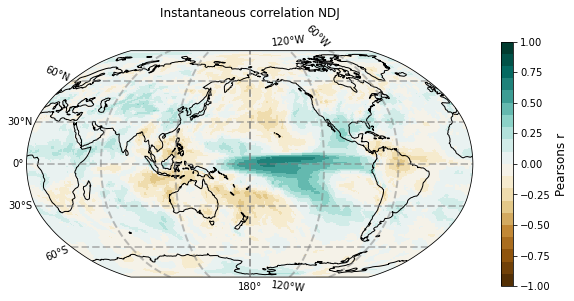

In [3]:
# Plot ensemble mean to check 
fig = plt.figure(figsize=(10,5))

vmin=-1
vmax=1

ax = fig.add_subplot(111, projection=ccrs.Robinson(180))
C = correlations.sel(month=11).mean(dim='member').plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap('BrBG', 20))
ax.coastlines()
ax.set_global()
ax.set_title('Instantaneous correlation NDJ')
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
# Colorbar
cbar = plt.colorbar(C, ax=ax, shrink=0.9, pad=0.05)
cbar.ax.set_ylabel('Pearsons r', fontsize=12)

# plt.savefig('ensemble_mean_corr_rx1.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)

In [16]:
# Calculate standrd deviation between ensemble members
ensemble_std_corr = np.apply_along_axis(np.std, 0, correlations)

In [17]:
# Covert to xarray
ensemble_std_corr = xr.DataArray(ensemble_std_corr, coords=correlations.mean(dim='member').coords)
# Save as netcdf 
ensemble_std_corr.to_netcdf('/g/data/w40/rl5183/20CR/precip/Rx1day_ensemble_std_corr_1901_2015.nc')